## This file contains three parts:

---
#### Part 1: VAE architecture, training and validating VAE model on the MNIST dataset and plots of the result.

#### Part 2: PPCA, calculation of the discrepancy of the original input data and reconstruction of the original data on the entire MNIST dataset via PPCA and VAE, reconstructed images by PPCA and VAE.

#### Part 3: Visualization of latent space for PPCA and VAE.



# Part 1: Defining necessary functions, preprocessing MNIST dataset and Training loop.

In [14]:
import torch 
import imageio
import numpy as np
from tqdm import tqdm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
to_pil_image = transforms.ToPILImage()

torch.manual_seed(1) # args.seed
torch.cuda.manual_seed(1) # cuda seed

def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"ConvVAE_Recon_Image" + str(epoch) + ".jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("ConvVAE_Loss" + str(epoch) + ".jpg")
    plt.show()


# from tqdm import tqdm
########  Define The Loss Function  ########
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss  # recontruction loss, mu: the mean from the latent vector, logvar: log variance from the latent vector
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return BCE + KLD


######## Define The Train Function ########

def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    # Initial value of the loss function
    running_loss = 0.0
    # Initial value of the reconstruction loss measured by Binary Cross Entropy(BCE)
    running_bce_loss=0.0
    # Initializes value of the counter 
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        running_bce_loss += bce_loss.item() 
        optimizer.step()
    # Calculate the average losses
    train_loss = running_loss / counter
    # Calculate the average bce_loss
    train_bce_loss = running_bce_loss / counter 
    return train_loss, train_bce_loss



######## Define The Validate Function ########

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    # Add a variable to store total bce_loss
    running_bce_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            running_bce_loss += bce_loss.item() 
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
                # Save the original images
                save_image(data.cpu(), f"MNIST_Original_Image.jpg")
    val_loss = running_loss / counter
    # Calculate the average bce_loss
    val_bce_loss = running_bce_loss / counter
    return val_loss, val_bce_loss, recon_images



########  Prepare the Variational Autoencoder Model  ########

import torch
import torch.nn as nn
import torch.nn.functional as F


######## Defining the Variational Autoencoder Class ########

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
 
        # encoder layers
        self.enc1 = nn.Linear(784, 400)
        self.enc2 = nn.Linear(400, 100)
        self.fc_mu = nn.Linear(100, 2) # 2D Latent space 
        self.fc_log_var = nn.Linear(100, 2) # 2D Latent space 
        # decoder layers
        self.fc1 = nn.Linear(2, 100) # 2D Latent space 
        self.dec1 = nn.Linear(100, 400)
        self.dec2 = nn.Linear(400, 784)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def decode(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.dec1(x))
        x = torch.sigmoid(self.dec2(x))
        return x

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std) # sampling
        return sample

    def forward(self, x):
        # encoding
        x = x.view(-1, 784) #784 is input size
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)

        # decoding
        z = self.decode(z)
        reconstruction = z.view(-1, 1, 28, 28) # reshape to include spatial dimensions
        return reconstruction, mu, log_var


######## Training Our Convolutional Variational Autoencoder on MNIST Dataset ########

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
matplotlib.style.use('ggplot')


# Setting the Computation Device and Learning Parameters 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = VAE().to(device)
# Set parameters
lr = 0.001
epochs = 101
batch_size = 128
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []


#### Prepare the Dataset ####
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
validationset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
validationloader = DataLoader(
    validationset, batch_size=batch_size, shuffle=False
)

#### The train loop ####


train_epoch_losses = []
val_epoch_losses = []
train_epoch_bce_losses = []
val_epoch_bce_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,train_epoch_bce_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, val_epoch_bce_loss, recon_images = validate(
        model, validationloader, validationset, device, criterion
    )
    train_epoch_losses.append(train_epoch_loss)
    train_epoch_bce_losses.append(train_epoch_bce_loss)
    val_epoch_losses.append(valid_epoch_loss)
    val_epoch_bce_losses.append(val_epoch_bce_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    # Print the losses
    print(f"Train Loss: {train_epoch_losses[-1]:.4f} | Train BCE Loss: {train_epoch_bce_losses[-1]:.4f}")
    print(f"Val Loss: {val_epoch_losses[-1]:.4f} | Validation BCE Loss: {val_epoch_bce_losses[-1]:.4f}")



Epoch 1 of 101


469it [00:18, 25.98it/s]                         
79it [00:02, 36.28it/s]                        


Train Loss: 24122.9330 | Train BCE Loss: 23635.8299
Val Loss: 21042.1459 | Validation BCE Loss: 20409.4222
Epoch 2 of 101


469it [00:18, 25.85it/s]
79it [00:02, 36.30it/s]                        


Train Loss: 20796.8489 | Train BCE Loss: 20124.3270
Val Loss: 20144.6965 | Validation BCE Loss: 19461.5570
Epoch 3 of 101


469it [00:18, 25.58it/s]                         
79it [00:02, 35.28it/s]                        


Train Loss: 20089.6389 | Train BCE Loss: 19378.0916
Val Loss: 19707.4109 | Validation BCE Loss: 19010.5055
Epoch 4 of 101


469it [00:17, 26.16it/s]                         
79it [00:02, 29.93it/s]                        


Train Loss: 19649.4531 | Train BCE Loss: 18914.1657
Val Loss: 19281.0776 | Validation BCE Loss: 18532.4339
Epoch 5 of 101


469it [00:17, 26.16it/s]                         
79it [00:02, 35.14it/s]                        


Train Loss: 19328.8735 | Train BCE Loss: 18574.7492
Val Loss: 19051.7952 | Validation BCE Loss: 18291.0283
Epoch 6 of 101


469it [00:19, 24.46it/s]                         
79it [00:02, 35.40it/s]                        


Train Loss: 19089.5297 | Train BCE Loss: 18318.7994
Val Loss: 18870.4780 | Validation BCE Loss: 18089.5236
Epoch 7 of 101


469it [00:18, 25.07it/s]                         
79it [00:02, 36.51it/s]                        


Train Loss: 18910.4163 | Train BCE Loss: 18132.7015
Val Loss: 18759.4176 | Validation BCE Loss: 17977.9815
Epoch 8 of 101


469it [00:20, 23.00it/s]                         
79it [00:02, 35.81it/s]                        


Train Loss: 18771.5217 | Train BCE Loss: 17985.8359
Val Loss: 18637.4472 | Validation BCE Loss: 17867.8309
Epoch 9 of 101


469it [00:18, 25.71it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 18660.6760 | Train BCE Loss: 17867.0511
Val Loss: 18563.6549 | Validation BCE Loss: 17791.6925
Epoch 10 of 101


469it [00:20, 23.29it/s]
79it [00:02, 36.39it/s]                        


Train Loss: 18559.5336 | Train BCE Loss: 17763.5186
Val Loss: 18496.9503 | Validation BCE Loss: 17724.0912
Epoch 11 of 101


469it [00:18, 25.39it/s]                         
79it [00:02, 37.18it/s]                        


Train Loss: 18497.1402 | Train BCE Loss: 17693.6856
Val Loss: 18448.8575 | Validation BCE Loss: 17657.7764
Epoch 12 of 101


469it [00:18, 25.87it/s]                         
79it [00:02, 37.61it/s]                        


Train Loss: 18426.8603 | Train BCE Loss: 17620.0953
Val Loss: 18397.3672 | Validation BCE Loss: 17603.9504
Epoch 13 of 101


469it [00:17, 26.25it/s]
79it [00:02, 31.34it/s]                        


Train Loss: 18354.8040 | Train BCE Loss: 17543.4728
Val Loss: 18382.4225 | Validation BCE Loss: 17573.8222
Epoch 14 of 101


469it [00:18, 26.04it/s]
79it [00:02, 36.72it/s]                        


Train Loss: 18289.2474 | Train BCE Loss: 17476.0253
Val Loss: 18305.2867 | Validation BCE Loss: 17498.4596
Epoch 15 of 101


469it [00:18, 25.61it/s]                         
79it [00:02, 37.18it/s]                        


Train Loss: 18227.5711 | Train BCE Loss: 17408.2162
Val Loss: 18269.9638 | Validation BCE Loss: 17458.1690
Epoch 16 of 101


469it [00:18, 25.39it/s]                         
79it [00:02, 36.36it/s]                        


Train Loss: 18186.7573 | Train BCE Loss: 17364.1982
Val Loss: 18238.6448 | Validation BCE Loss: 17442.3468
Epoch 17 of 101


469it [00:17, 26.17it/s]                         
79it [00:02, 33.89it/s]                        


Train Loss: 18145.6538 | Train BCE Loss: 17319.8583
Val Loss: 18170.7085 | Validation BCE Loss: 17356.6492
Epoch 18 of 101


469it [00:18, 25.82it/s]                         
79it [00:02, 36.77it/s]                        


Train Loss: 18103.9271 | Train BCE Loss: 17274.9133
Val Loss: 18114.9550 | Validation BCE Loss: 17320.4626
Epoch 19 of 101


469it [00:18, 25.89it/s]                         
79it [00:02, 36.75it/s]                        


Train Loss: 18064.2945 | Train BCE Loss: 17233.7115
Val Loss: 18131.9456 | Validation BCE Loss: 17305.8146
Epoch 20 of 101


469it [00:18, 25.30it/s]                         
79it [00:02, 33.05it/s]                        


Train Loss: 18011.3547 | Train BCE Loss: 17175.5280
Val Loss: 18097.9471 | Validation BCE Loss: 17288.8555
Epoch 21 of 101


469it [00:18, 25.83it/s]                         
79it [00:02, 35.00it/s]                        


Train Loss: 17975.1444 | Train BCE Loss: 17138.1507
Val Loss: 18097.0043 | Validation BCE Loss: 17270.1963
Epoch 22 of 101


469it [00:18, 25.73it/s]                         
79it [00:02, 36.36it/s]                        


Train Loss: 17940.7624 | Train BCE Loss: 17098.8221
Val Loss: 18026.5317 | Validation BCE Loss: 17182.6882
Epoch 23 of 101


469it [00:18, 25.86it/s]                         
79it [00:02, 36.00it/s]                        


Train Loss: 17913.4292 | Train BCE Loss: 17070.6272
Val Loss: 18060.2324 | Validation BCE Loss: 17232.7101
Epoch 24 of 101


469it [00:17, 26.69it/s]                         
79it [00:02, 30.56it/s]                        


Train Loss: 17874.8375 | Train BCE Loss: 17028.1288
Val Loss: 18036.6201 | Validation BCE Loss: 17192.4113
Epoch 25 of 101


469it [00:17, 26.31it/s]                         
79it [00:02, 36.15it/s]                        


Train Loss: 17849.4948 | Train BCE Loss: 17000.8511
Val Loss: 18004.9874 | Validation BCE Loss: 17145.0416
Epoch 26 of 101


469it [00:18, 25.27it/s]                         
79it [00:02, 37.31it/s]                        


Train Loss: 17829.2782 | Train BCE Loss: 16981.0080
Val Loss: 17997.6738 | Validation BCE Loss: 17165.0629
Epoch 27 of 101


469it [00:18, 25.82it/s]                         
79it [00:02, 36.62it/s]                        


Train Loss: 17784.5364 | Train BCE Loss: 16930.9604
Val Loss: 17957.7966 | Validation BCE Loss: 17121.5356
Epoch 28 of 101


469it [00:17, 26.54it/s]                         
79it [00:02, 31.56it/s]                        


Train Loss: 17753.9309 | Train BCE Loss: 16898.0539
Val Loss: 18019.8110 | Validation BCE Loss: 17180.5554
Epoch 29 of 101


469it [00:18, 25.88it/s]                         
79it [00:02, 36.85it/s]                        


Train Loss: 17731.9767 | Train BCE Loss: 16873.9262
Val Loss: 17964.6543 | Validation BCE Loss: 17118.9673
Epoch 30 of 101


469it [00:18, 25.56it/s]                         
79it [00:02, 36.36it/s]                        


Train Loss: 17705.5519 | Train BCE Loss: 16846.0554
Val Loss: 17964.2510 | Validation BCE Loss: 17115.5701
Epoch 31 of 101


469it [00:18, 25.44it/s]                         
79it [00:02, 36.41it/s]                        


Train Loss: 17683.2490 | Train BCE Loss: 16821.0824
Val Loss: 17912.8456 | Validation BCE Loss: 17077.0471
Epoch 32 of 101


469it [00:17, 26.22it/s]                         
79it [00:02, 34.61it/s]                        


Train Loss: 17679.2327 | Train BCE Loss: 16814.9664
Val Loss: 17887.8646 | Validation BCE Loss: 17057.9073
Epoch 33 of 101


469it [00:17, 26.09it/s]                         
79it [00:02, 35.81it/s]                        


Train Loss: 17664.8807 | Train BCE Loss: 16800.8606
Val Loss: 17907.7818 | Validation BCE Loss: 17072.3165
Epoch 34 of 101


469it [00:18, 25.67it/s]                         
79it [00:02, 36.86it/s]                        


Train Loss: 17638.4549 | Train BCE Loss: 16770.6281
Val Loss: 17888.5055 | Validation BCE Loss: 17028.6323
Epoch 35 of 101


469it [00:18, 25.58it/s]                         
79it [00:02, 31.84it/s]


Train Loss: 17601.9636 | Train BCE Loss: 16734.0153
Val Loss: 17928.3610 | Validation BCE Loss: 17080.2833
Epoch 36 of 101


469it [00:18, 25.82it/s]                         
79it [00:02, 36.26it/s]                        


Train Loss: 17590.5615 | Train BCE Loss: 16721.9571
Val Loss: 17906.3592 | Validation BCE Loss: 17048.8293
Epoch 37 of 101


469it [00:18, 25.81it/s]
79it [00:02, 37.09it/s]                        


Train Loss: 17585.1488 | Train BCE Loss: 16713.3707
Val Loss: 17889.1296 | Validation BCE Loss: 17020.9776
Epoch 38 of 101


469it [00:18, 25.84it/s]                         
79it [00:02, 36.20it/s]                        


Train Loss: 17550.3587 | Train BCE Loss: 16677.3766
Val Loss: 17846.7353 | Validation BCE Loss: 16967.1183
Epoch 39 of 101


469it [00:17, 26.14it/s]                         
79it [00:02, 30.64it/s]                        


Train Loss: 17528.7636 | Train BCE Loss: 16652.2791
Val Loss: 17876.6776 | Validation BCE Loss: 17010.2853
Epoch 40 of 101


469it [00:18, 26.00it/s]                         
79it [00:02, 36.22it/s]                        


Train Loss: 17522.9374 | Train BCE Loss: 16645.6797
Val Loss: 17873.2475 | Validation BCE Loss: 16987.2908
Epoch 41 of 101


469it [00:21, 21.50it/s]
79it [00:02, 35.85it/s]


Train Loss: 17492.3965 | Train BCE Loss: 16616.1591
Val Loss: 17837.3290 | Validation BCE Loss: 16974.9505
Epoch 42 of 101


469it [00:21, 22.24it/s]                         
79it [00:02, 36.34it/s]                        


Train Loss: 17475.7638 | Train BCE Loss: 16597.6765
Val Loss: 17857.7861 | Validation BCE Loss: 17008.7498
Epoch 43 of 101


469it [00:18, 25.76it/s]
79it [00:02, 36.17it/s]                        


Train Loss: 17466.5562 | Train BCE Loss: 16587.2703
Val Loss: 17814.8630 | Validation BCE Loss: 16933.7161
Epoch 44 of 101


469it [00:18, 25.84it/s]                         
79it [00:02, 36.43it/s]                        


Train Loss: 17453.8434 | Train BCE Loss: 16572.4269
Val Loss: 17821.4156 | Validation BCE Loss: 16946.0489
Epoch 45 of 101


469it [00:17, 26.32it/s]
79it [00:02, 29.97it/s]                        


Train Loss: 17444.7698 | Train BCE Loss: 16562.3618
Val Loss: 17837.4723 | Validation BCE Loss: 16971.5863
Epoch 46 of 101


469it [00:18, 25.90it/s]                         
79it [00:02, 36.41it/s]                        


Train Loss: 17451.1475 | Train BCE Loss: 16567.2145
Val Loss: 17825.3425 | Validation BCE Loss: 16952.2108
Epoch 47 of 101


469it [00:18, 25.83it/s]                         
79it [00:02, 36.20it/s]                        


Train Loss: 17422.1705 | Train BCE Loss: 16535.9283
Val Loss: 17830.5242 | Validation BCE Loss: 16974.9143
Epoch 48 of 101


469it [00:19, 23.82it/s]
79it [00:02, 35.54it/s]                        


Train Loss: 17401.9401 | Train BCE Loss: 16516.4735
Val Loss: 17820.7203 | Validation BCE Loss: 16958.0807
Epoch 49 of 101


469it [00:17, 26.40it/s]                         
79it [00:02, 30.62it/s]                        


Train Loss: 17397.8166 | Train BCE Loss: 16510.5114
Val Loss: 17850.4880 | Validation BCE Loss: 16986.5680
Epoch 50 of 101


469it [00:18, 25.22it/s]                         
79it [00:02, 36.74it/s]                        


Train Loss: 17379.7035 | Train BCE Loss: 16491.9979
Val Loss: 17760.9384 | Validation BCE Loss: 16886.6928
Epoch 51 of 101


469it [00:18, 24.96it/s]                         
79it [00:03, 25.90it/s]                        


Train Loss: 17355.4952 | Train BCE Loss: 16465.3748
Val Loss: 17801.1271 | Validation BCE Loss: 16925.6987
Epoch 52 of 101


469it [00:22, 21.02it/s]                         
79it [00:02, 36.53it/s]                        


Train Loss: 17357.8158 | Train BCE Loss: 16467.8105
Val Loss: 17810.8655 | Validation BCE Loss: 16932.3500
Epoch 53 of 101


469it [00:18, 25.04it/s]                         
79it [00:02, 35.90it/s]                        


Train Loss: 17346.7206 | Train BCE Loss: 16454.1573
Val Loss: 17778.6585 | Validation BCE Loss: 16894.7145
Epoch 54 of 101


469it [00:18, 25.37it/s]
79it [00:02, 35.31it/s]                        


Train Loss: 17321.2805 | Train BCE Loss: 16429.0960
Val Loss: 17896.1937 | Validation BCE Loss: 17032.0103
Epoch 55 of 101


469it [00:18, 25.72it/s]                         
79it [00:03, 25.64it/s]                        


Train Loss: 17324.6519 | Train BCE Loss: 16431.4048
Val Loss: 17825.1429 | Validation BCE Loss: 16934.3372
Epoch 56 of 101


469it [00:19, 24.49it/s]                         
79it [00:02, 36.26it/s]                        


Train Loss: 17328.5008 | Train BCE Loss: 16435.3057
Val Loss: 17825.3755 | Validation BCE Loss: 16942.7711
Epoch 57 of 101


469it [00:18, 24.93it/s]
79it [00:02, 36.30it/s]                        


Train Loss: 17307.7442 | Train BCE Loss: 16412.0084
Val Loss: 17796.1831 | Validation BCE Loss: 16916.3723
Epoch 58 of 101


469it [00:18, 25.31it/s]                         
79it [00:02, 36.69it/s]                        


Train Loss: 17292.5742 | Train BCE Loss: 16395.2881
Val Loss: 17816.1826 | Validation BCE Loss: 16933.3418
Epoch 59 of 101


469it [00:18, 25.98it/s]                         
79it [00:02, 33.01it/s]                        


Train Loss: 17282.4066 | Train BCE Loss: 16384.2132
Val Loss: 17762.8222 | Validation BCE Loss: 16883.8515
Epoch 60 of 101


469it [00:17, 26.22it/s]                         
79it [00:02, 36.79it/s]                        


Train Loss: 17271.4417 | Train BCE Loss: 16374.4820
Val Loss: 17786.3508 | Validation BCE Loss: 16906.3729
Epoch 61 of 101


469it [00:18, 25.60it/s]                         
79it [00:02, 36.34it/s]                        


Train Loss: 17257.2673 | Train BCE Loss: 16357.3956
Val Loss: 17826.8803 | Validation BCE Loss: 16941.3502
Epoch 62 of 101


469it [00:18, 25.81it/s]                         
79it [00:02, 36.47it/s]                        


Train Loss: 17261.4181 | Train BCE Loss: 16361.1696
Val Loss: 17801.1039 | Validation BCE Loss: 16899.1507
Epoch 63 of 101


469it [00:17, 26.31it/s]                         
79it [00:02, 30.93it/s]                        


Train Loss: 17255.0383 | Train BCE Loss: 16353.6626
Val Loss: 17771.7261 | Validation BCE Loss: 16899.5448
Epoch 64 of 101


469it [00:17, 26.30it/s]                         
79it [00:02, 36.24it/s]                        


Train Loss: 17227.0989 | Train BCE Loss: 16325.3676
Val Loss: 17783.0806 | Validation BCE Loss: 16877.2609
Epoch 65 of 101


469it [00:18, 25.67it/s]                         
79it [00:02, 36.50it/s]                        


Train Loss: 17235.4618 | Train BCE Loss: 16330.8623
Val Loss: 17785.9050 | Validation BCE Loss: 16897.6594
Epoch 66 of 101


469it [00:18, 25.42it/s]                         
79it [00:02, 36.27it/s]                        


Train Loss: 17230.4884 | Train BCE Loss: 16326.0991
Val Loss: 17794.1011 | Validation BCE Loss: 16908.7322
Epoch 67 of 101


469it [00:17, 26.30it/s]                         
79it [00:02, 32.72it/s]


Train Loss: 17213.8070 | Train BCE Loss: 16308.2868
Val Loss: 17748.0881 | Validation BCE Loss: 16859.9374
Epoch 68 of 101


469it [00:17, 26.16it/s]                         
79it [00:02, 36.87it/s]                        


Train Loss: 17191.3670 | Train BCE Loss: 16284.0702
Val Loss: 17728.6531 | Validation BCE Loss: 16833.2937
Epoch 69 of 101


469it [00:18, 25.76it/s]                         
79it [00:02, 36.64it/s]                        


Train Loss: 17221.9319 | Train BCE Loss: 16316.2233
Val Loss: 17802.3565 | Validation BCE Loss: 16919.2468
Epoch 70 of 101


469it [00:18, 25.73it/s]                         
79it [00:02, 30.71it/s]                        


Train Loss: 17194.7963 | Train BCE Loss: 16289.3545
Val Loss: 17785.7873 | Validation BCE Loss: 16891.4326
Epoch 71 of 101


469it [00:17, 26.44it/s]                         
79it [00:02, 35.46it/s]                        


Train Loss: 17166.8976 | Train BCE Loss: 16259.0260
Val Loss: 17766.1402 | Validation BCE Loss: 16873.0413
Epoch 72 of 101


469it [00:18, 25.93it/s]                         
79it [00:02, 36.78it/s]                        


Train Loss: 17208.8640 | Train BCE Loss: 16301.8117
Val Loss: 17805.3637 | Validation BCE Loss: 16913.4236
Epoch 73 of 101


469it [00:18, 25.82it/s]                         
79it [00:02, 36.76it/s]                        


Train Loss: 17162.7408 | Train BCE Loss: 16251.4307
Val Loss: 17759.8492 | Validation BCE Loss: 16863.1094
Epoch 74 of 101


469it [00:17, 26.42it/s]                         
79it [00:02, 30.51it/s]                        


Train Loss: 17152.0613 | Train BCE Loss: 16242.1955
Val Loss: 17794.0982 | Validation BCE Loss: 16888.7750
Epoch 75 of 101


469it [00:17, 26.18it/s]                         
79it [00:02, 33.28it/s]                        


Train Loss: 17142.6069 | Train BCE Loss: 16229.3917
Val Loss: 17773.2655 | Validation BCE Loss: 16881.5398
Epoch 76 of 101


469it [00:18, 25.86it/s]                         
79it [00:02, 36.21it/s]                        


Train Loss: 17149.3445 | Train BCE Loss: 16237.2530
Val Loss: 17760.6431 | Validation BCE Loss: 16863.0791
Epoch 77 of 101


469it [00:18, 25.47it/s]                         
79it [00:02, 36.64it/s]                        


Train Loss: 17145.7201 | Train BCE Loss: 16232.2218
Val Loss: 17796.3694 | Validation BCE Loss: 16883.5605
Epoch 78 of 101


469it [00:20, 23.44it/s]
79it [00:02, 28.52it/s]                        


Train Loss: 17130.4156 | Train BCE Loss: 16216.9706
Val Loss: 17759.0200 | Validation BCE Loss: 16868.5982
Epoch 79 of 101


469it [00:20, 22.61it/s]                         
79it [00:02, 30.40it/s]                        


Train Loss: 17131.6454 | Train BCE Loss: 16217.9151
Val Loss: 17763.0090 | Validation BCE Loss: 16839.9616
Epoch 80 of 101


469it [00:19, 23.47it/s]                         
79it [00:03, 23.78it/s]                        


Train Loss: 17119.6336 | Train BCE Loss: 16202.4112
Val Loss: 17853.0592 | Validation BCE Loss: 16932.7182
Epoch 81 of 101


469it [00:18, 25.15it/s]                         
79it [00:02, 33.97it/s]                        


Train Loss: 17116.2347 | Train BCE Loss: 16202.4574
Val Loss: 17794.9464 | Validation BCE Loss: 16895.6404
Epoch 82 of 101


469it [00:18, 25.65it/s]                         
79it [00:02, 36.16it/s]                        


Train Loss: 17102.2900 | Train BCE Loss: 16185.1370
Val Loss: 17791.3985 | Validation BCE Loss: 16901.1802
Epoch 83 of 101


469it [00:18, 25.28it/s]                         
79it [00:02, 36.30it/s]                        


Train Loss: 17083.5238 | Train BCE Loss: 16166.1643
Val Loss: 17726.9907 | Validation BCE Loss: 16833.1577
Epoch 84 of 101


469it [00:19, 24.16it/s]
79it [00:02, 35.80it/s]                        


Train Loss: 17086.5044 | Train BCE Loss: 16167.9648
Val Loss: 17777.6528 | Validation BCE Loss: 16883.4032
Epoch 85 of 101


469it [00:18, 25.67it/s]                         
79it [00:02, 28.23it/s]                        


Train Loss: 17086.5062 | Train BCE Loss: 16169.3892
Val Loss: 17748.8021 | Validation BCE Loss: 16848.1425
Epoch 86 of 101


469it [00:18, 25.88it/s]                         
79it [00:02, 36.73it/s]                        


Train Loss: 17083.7367 | Train BCE Loss: 16166.4565
Val Loss: 17829.2264 | Validation BCE Loss: 16929.7893
Epoch 87 of 101


469it [00:18, 25.55it/s]                         
79it [00:02, 36.61it/s]                        


Train Loss: 17075.7840 | Train BCE Loss: 16157.1268
Val Loss: 17709.5300 | Validation BCE Loss: 16818.2273
Epoch 88 of 101


469it [00:18, 25.40it/s]                         
79it [00:02, 36.28it/s]                        


Train Loss: 17052.8013 | Train BCE Loss: 16132.1027
Val Loss: 17732.3257 | Validation BCE Loss: 16820.4547
Epoch 89 of 101


469it [00:18, 25.97it/s]                         
79it [00:02, 30.09it/s]                        


Train Loss: 17065.8670 | Train BCE Loss: 16145.9709
Val Loss: 17749.5173 | Validation BCE Loss: 16840.5956
Epoch 90 of 101


469it [00:18, 25.65it/s]                         
79it [00:02, 32.57it/s]                        


Train Loss: 17051.3646 | Train BCE Loss: 16129.1843
Val Loss: 17723.9379 | Validation BCE Loss: 16816.6353
Epoch 91 of 101


469it [00:18, 24.91it/s]
79it [00:02, 35.51it/s]                        


Train Loss: 17039.7828 | Train BCE Loss: 16116.9630
Val Loss: 17773.0585 | Validation BCE Loss: 16862.7317
Epoch 92 of 101


469it [00:18, 25.05it/s]                         
79it [00:02, 36.54it/s]                        


Train Loss: 17047.6349 | Train BCE Loss: 16124.5665
Val Loss: 17724.4523 | Validation BCE Loss: 16816.7924
Epoch 93 of 101


469it [00:18, 25.70it/s]                         
79it [00:02, 30.02it/s]                        


Train Loss: 17040.2614 | Train BCE Loss: 16117.2761
Val Loss: 17809.8337 | Validation BCE Loss: 16902.4870
Epoch 94 of 101


469it [00:17, 26.20it/s]                         
79it [00:02, 36.46it/s]                        


Train Loss: 17020.8495 | Train BCE Loss: 16098.1206
Val Loss: 17780.2196 | Validation BCE Loss: 16876.3391
Epoch 95 of 101


469it [00:18, 25.42it/s]                         
79it [00:02, 32.62it/s]                        


Train Loss: 17016.0307 | Train BCE Loss: 16090.8813
Val Loss: 17777.3073 | Validation BCE Loss: 16859.6834
Epoch 96 of 101


469it [00:18, 25.52it/s]                         
79it [00:02, 36.63it/s]                        


Train Loss: 17029.4742 | Train BCE Loss: 16105.4201
Val Loss: 17755.5062 | Validation BCE Loss: 16846.2714
Epoch 97 of 101


469it [00:18, 25.88it/s]                         
79it [00:02, 31.66it/s]                        


Train Loss: 17005.6389 | Train BCE Loss: 16079.5163
Val Loss: 17779.6446 | Validation BCE Loss: 16877.3114
Epoch 98 of 101


469it [00:18, 25.72it/s]                         
79it [00:02, 35.93it/s]                        


Train Loss: 17003.4315 | Train BCE Loss: 16077.7151
Val Loss: 17768.2232 | Validation BCE Loss: 16841.7783
Epoch 99 of 101


469it [00:18, 25.48it/s]                         
79it [00:02, 35.48it/s]                        


Train Loss: 17009.5425 | Train BCE Loss: 16082.3340
Val Loss: 17762.4148 | Validation BCE Loss: 16855.5089
Epoch 100 of 101


469it [00:18, 25.28it/s]                         
79it [00:02, 36.44it/s]                        


Train Loss: 17020.6905 | Train BCE Loss: 16093.8070
Val Loss: 17778.2465 | Validation BCE Loss: 16870.4725
Epoch 101 of 101


469it [00:18, 25.72it/s]                         
79it [00:02, 32.22it/s]                        

Train Loss: 17005.5888 | Train BCE Loss: 16078.3564
Val Loss: 17792.9565 | Validation BCE Loss: 16886.1427


## Below is the visualisation of final Loss and reconstruction Loss.
## Plot of the loss function value

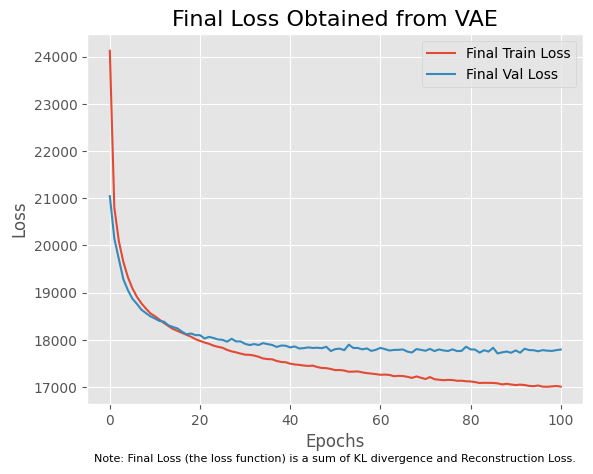

In [15]:
plt.plot(train_epoch_losses, label="Final Train Loss")
plt.plot(val_epoch_losses, label="Final Val Loss")
plt.legend()
plt.title("Final Loss Obtained from VAE", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.annotate('Note: Final Loss (the loss function) is a sum of KL divergence and Reconstruction Loss.',
                 xy=(0.5, 0), xytext=(0.5, -0.15),
                 xycoords='axes fraction', textcoords='axes fraction',
                 fontsize=8, ha='center', va='center')
plt.show()

## Plot of reconstruction loss

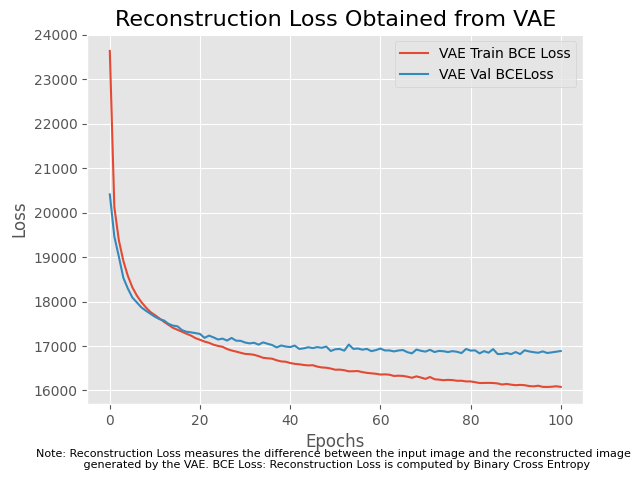

In [16]:
plt.plot(train_epoch_bce_losses, label="VAE Train BCE Loss")
plt.plot(val_epoch_bce_losses, label="VAE Val BCELoss")
plt.legend()
plt.title("Reconstruction Loss Obtained from VAE", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.annotate('Note: Reconstruction Loss measures the difference between the input image and the reconstructed image \n generated by the VAE. BCE Loss: Reconstruction Loss is computed by Binary Cross Entropy',
                 xy=(0.5, 0), xytext=(0.5, -0.15),
                 xycoords='axes fraction', textcoords='axes fraction',
                 fontsize=8, ha='center', va='center')
plt.show()

## A commbined plot

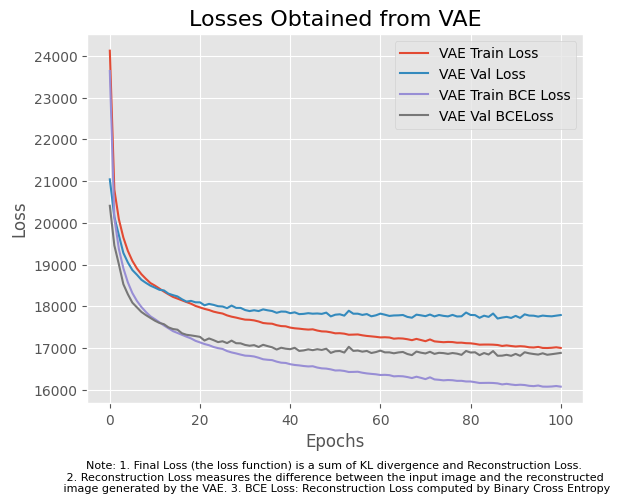

In [ ]:
plt.plot(train_epoch_losses, label="VAE Train Loss")
plt.plot(val_epoch_losses, label="VAE Val Loss")
plt.plot(train_epoch_bce_losses, label="VAE Train BCE Loss")
plt.plot(val_epoch_bce_losses, label="VAE Val BCELoss")
plt.legend()
plt.title("Losses Obtained from VAE", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.annotate('Note: 1. Final Loss (the loss function) is a sum of KL divergence and Reconstruction Loss. \n 2. Reconstruction Loss measures the difference between the input image and the reconstructed \n image generated by the VAE. 3. BCE Loss: Reconstruction Loss computed by Binary Cross Entropy',
                 xy=(0.5, 0), xytext=(0.5, -0.2),
                 xycoords='axes fraction', textcoords='axes fraction',
                 fontsize=8, ha='center', va='center')

plt.show()

# Part 2: PPCA

In [17]:
import numpy as np
import torch
torch.manual_seed(1)
torch.cuda.manual_seed(1)
batch_size=20
n_iter=batch_size # This was set to be 128 before, but by ploting the loss, i found that it already converges around iterations 15-18. so n_iter sat to be 20 here

########  Defining PPCA  ########
def ppcat(X, K, n_iter):
    N, D = X.shape
    X_mean = torch.mean(X, 0)
    X_centered = X - X_mean
    
    # Initialize W randomly
    W = torch.randn(D, K)
    
    # PPCA using the EM algorithm
    losses = []
    for _ in range(n_iter):
        # E-step: Compute the posterior distribution over the latent variables Z
        M = torch.inverse(torch.eye(K) + W.T @ W)
        Z = X_centered @ W @ M

        # M-step: Update W
        W = X_centered.T @ Z @ torch.inverse(Z.T @ Z)

        # Compute the loss (reconstruction error)
        X_reconstructed = Z @ W.T + X_mean
        loss = torch.mean((X - X_reconstructed) ** 2)
        losses.append(loss.item())
    
    return Z, W, losses

########  Prepare the MNIST dataset ######## 
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
validationset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
validationloader = DataLoader(
    validationset, batch_size=batch_size, shuffle=False
)


# Reshape and normalize train data and validation data
train_data_vec = trainset.data.float().view(-1, 28*28) / 255.
validation_data_vec = validationset.data.float().view(-1, 28*28) / 255.


# Perform PPCA with 2 latent dimensions and plot results
Z_train, U_M_train, losses_train = ppcat(train_data_vec, 2,batch_size)
Z_validation, U_M_validation, losses_validation = ppcat(validation_data_vec, 2,batch_size)

# Print the final PPCA loss
print("PPCA Train Loss:", losses_train[-1])
print("PPCA validation Loss:", losses_validation[-1])

# Combine train_data_vec and validation_data_vec
data_vec = torch.cat([train_data_vec, validation_data_vec], dim=0)

# Reconstruct the images using VAE
with torch.no_grad():
    data_tensor = torch.tensor(data_vec).to(device)
    reconstructions, _, _ = model(data_tensor)
    vae_reconstructions = reconstructions.cpu().numpy()

# Flatten the 4D tensor into a 2D tensor
vae_reconstructions = vae_reconstructions.reshape(-1, 784)

########  Calculate the VAE reconstruction loss (MSE) for the entire dataset. ########
vae_mse_all = torch.mean((data_vec - vae_reconstructions) ** 2)
print("VAE Reconstruction Loss (MSE) for entire dataset:", vae_mse_all.item())


PPCA Train Loss: 0.05595472827553749
PPCA validation Loss: 0.055550094693899155


<ipython-input-17-0c0a5485b2f6>:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data_vec).to(device)


VAE Reconstruction Loss (MSE) for entire dataset: 0.0335000641644001


## Reconstructed Images via PPCA and VAE

<ipython-input-19-7f8416f0d380>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data_vec).to(device)


PPCA Reconstruction Loss (MSE) for entire dataset: 0.10091228783130646


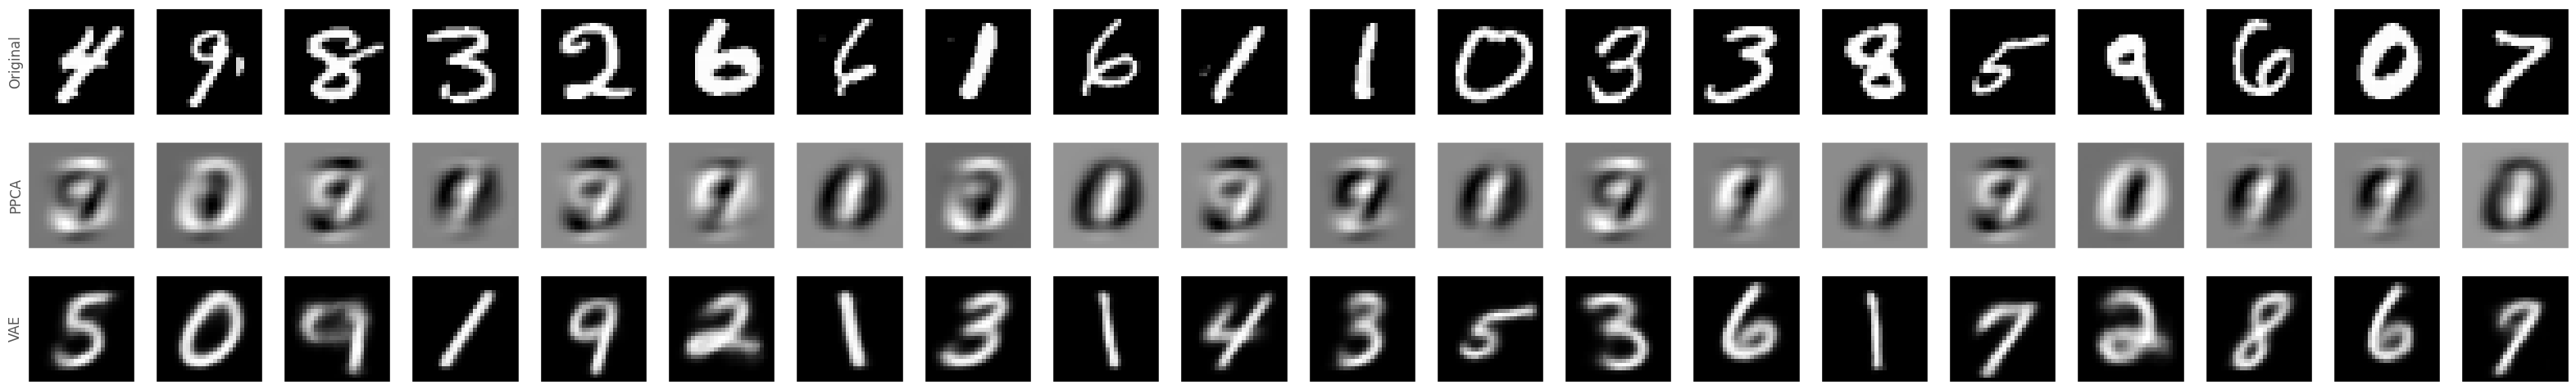

In [19]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Select a few sample images
num_samples = 20
sample_indices = np.random.choice(len(data_vec), num_samples, replace=False)
samples = data_vec[sample_indices]

# Reconstruct the images using PPCA
Z_all, U_M, losses = ppcat(data_vec, 2, batch_size)
ppca_reconstructions_all = Z_all @ U_M.T

# Reconstruct the images using VAE
with torch.no_grad():
    data_tensor = torch.tensor(data_vec).to(device)
    reconstructions_all, _, _ = model(data_tensor)
    vae_reconstructions_all = reconstructions_all.cpu().numpy()

# Reshape the reconstructed image to its original shape
ppca_reconstructions_all = ppca_reconstructions_all.reshape(-1, 784)
vae_reconstructions_all = vae_reconstructions_all.reshape(-1, 28, 28)

########  Calculate the PPCA reconstruction loss (MSE) for the entire dataset. ######## 
ppca_mse_all = torch.mean((data_vec - ppca_reconstructions_all) ** 2)
print("PPCA Reconstruction Loss (MSE) for entire dataset:", ppca_mse_all.item())


# Visualize the original images, PPCA-reconstructed images, and VAE-reconstructed images
fig, axs = plt.subplots(3, num_samples, figsize=(num_samples*2, 6))

for i in range(num_samples):
    axs[0, i].imshow(samples[i].reshape(28, 28), cmap='gray')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].imshow(ppca_reconstructions_all[i].reshape(28, 28), cmap='gray')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[2, i].imshow(vae_reconstructions_all[i].reshape(28, 28), cmap='gray')
    axs[2, i].set_xticks([])
    axs[2, i].set_yticks([])

axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('PPCA')
axs[2, 0].set_ylabel('VAE')
plt.savefig("PPCA vs VAE" + ".jpg")

plt.show()

# Part 3: Visualization of PPCA and VAE latent space
#### This part will help us to assess the structure of thee reduced-dimensional(low-dimensional) representation of the MNIST dataset. This allows us to see which model is better at capturing the spatial features and relationships of the MNIST dataset. More concretly speaking, separating and distinguish between different digits of input datain the low-dimensional space. The model who has a latent space that has clear and distinguish clusters for the corresponding digits performs better in terms of capturing the underlying structure

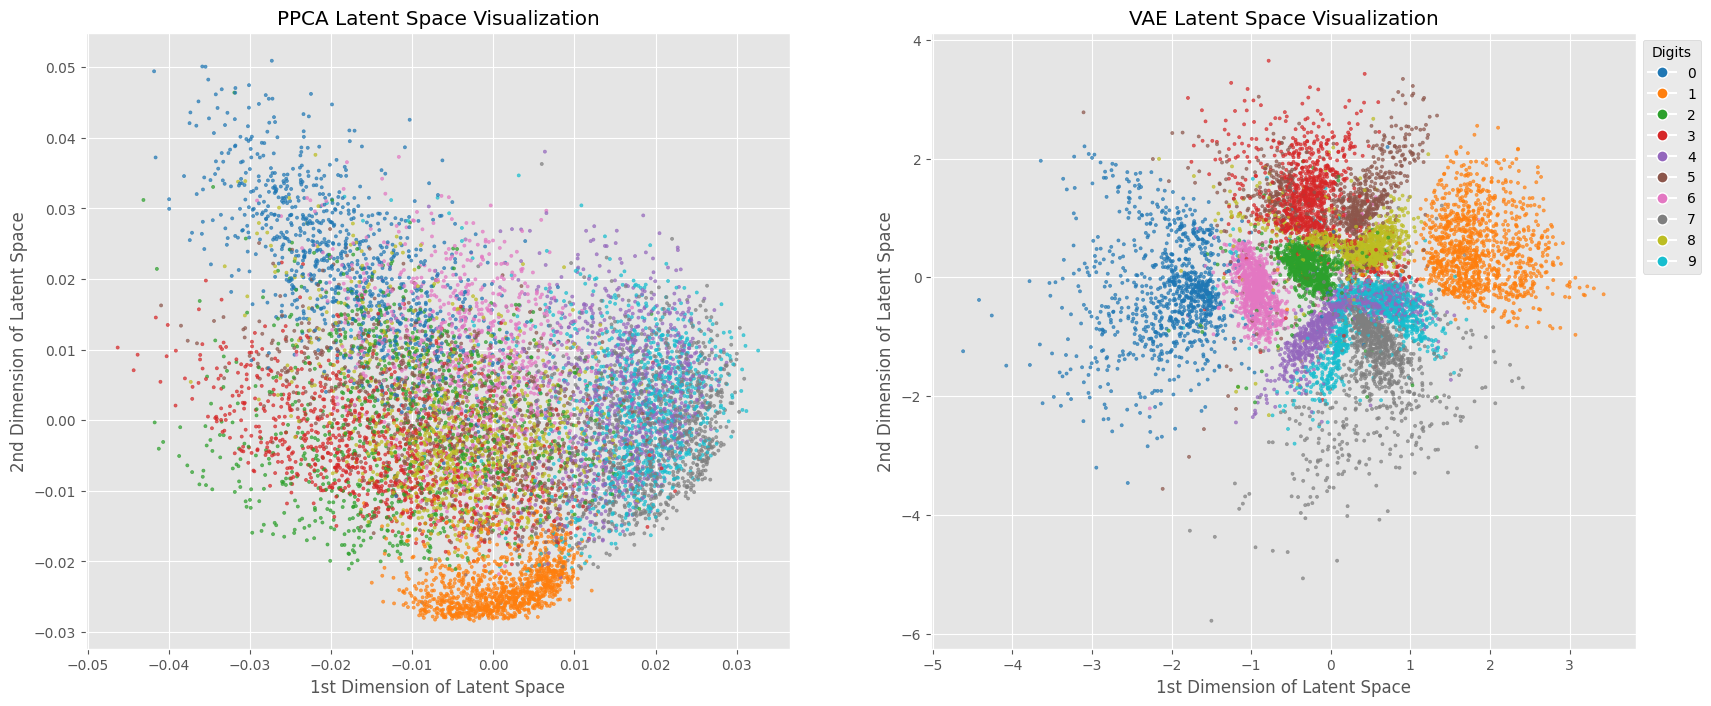

In [24]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

def visualize_ppca_latent_space(Z, labels, ax):
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)

    # Create a dictionary to map label values to colors used in the scatter plot
    label_to_color = {label: scatter.to_rgba(label) for label in np.unique(labels)}

    # Create legend handles and labels manually
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                  markerfacecolor=color, markersize=8)
                       for label, color in label_to_color.items()]

    # Add the legend to the plot
    ax.set_xlabel("1st Dimension of Latent Space")
    ax.set_ylabel("2nd Dimension of Latent Space")
    ax.set_title("PPCA Latent Space Visualization")


def visualize_latent_space(model, dataloader, dataset, device, ax):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            img, label = data
            img = img.to(device)
            mu, _ = model.encode(img.view(-1, 784))
            latents.append(mu.cpu().numpy())
            labels.append(label.numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    scatter = ax.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)

    label_to_color = {label: scatter.to_rgba(label) for label in np.unique(labels)}

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                  markerfacecolor=color, markersize=8)
                       for label, color in label_to_color.items()]

    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title='Digits')
    ax.set_xlabel("1st Dimension of Latent Space")
    ax.set_ylabel("2nd Dimension of Latent Space")
    ax.set_title("VAE Latent Space Visualization")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Get the labels for the validation dataset
validation_labels = validationset.targets.numpy()

# Visualize the PPCA latent space
visualize_ppca_latent_space(Z_validation.numpy(), validation_labels, ax1)

# Visualize the VAE latent space
visualize_latent_space(model, validationloader, validationset, device, ax2)

plt.show()



